# GUIDELINE
## Last:
> * Spline basis generation with new lib (patsy)
> * new shapes no get_data ('scale' maybe required pra fazer os splines)
> * Melhorar o parsing do get data para implementar o sliding window (train,test split) 
## Next:
> * Implementar PCA trad (PCA + OLS)
> * Entender a metrica de comparação (p/ F e Lambda)
> * Simulação de dados calibrados c real data ?
> * plotar as resultantes das somas das splines
> * usar o J com formula no sieve

In [1]:
%matplotlib inline 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# info
info = pd.read_csv('./data/info_charact.csv', index_col = 0)
char_names = info.iloc[:, 0]
file_names = np.array([str(x) + '.csv' for x in info.index.values])
d = len(info)-1

In [3]:
# New idea : sliding window average
# X_train = [start,final] and X_test = [start+1,final+1]
# i.e. for each time input X, we average a composed target range including itself

# disc: for Y_test we only care about Y_test[-1] (returns for the target month)
def get_data_(start_date: int = 0, final_date: int = 24, shape: str = '') -> tuple[pd.DataFrame, pd.DataFrame] :
    
    parse = lambda  x : pd.read_csv(f'./data/{x}', index_col = 0, parse_dates = True)
    
    # filter NaN values 
    data_list = [parse(file).iloc[start_date:final_date+1, :] for file in file_names if file != '44.csv']
    asset_names = list(set.intersection(*[set(df.dropna(axis=1).columns.values) for df in data_list]))
    
    # get features 
    X_train = pd.DataFrame(data=[df[asset_names].iloc[:-1,:].mean() for df in data_list], index=list(char_names[:-1])).T
    X_test = pd.DataFrame(data=[df[asset_names].iloc[1:,:].mean() for df in data_list], index=list(char_names[:-1])).T
    
    # get returns [range]
    Y = parse('44.csv')[asset_names].T
    Y_train, Y_test = Y.iloc[:, start_date:final_date], Y.iloc[:, start_date+1:final_date+1]
    
    # choice of shapes'
    # normalize (column ~ [0 mean, 1 std])
    if shape == 'std':
        norm  = lambda x : (x-x.mean())/x.std()
        X_train, X_test = norm(X_train), norm(X_test)
    
    # scale (column ~ [0,1] range)
    elif shape == 'maxmin':
        scale = lambda x : (x-x.min())/(x.max()-x.min())
        X_train, X_test = scale(X_train), scale(X_test)
     
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = get_data_(0,24, 'std')
display(X_train.head())
display(Y_train.head())

,size,valueAnnual,piotroski,debtIssue,shareIssue,assetGrowth,assetTurnover,divYld,earningsToPrice,cashFlowToMarket,...,idioVol,beta,seasonality,indRelativeReversal,indMomRev,compositeIssuance,price,firmAge,shareVol,benchmarkWeight
2216850,0.155746,1.549276,0.376366,-0.690443,1.483363,1.023610,-0.539247,1.534317,1.594859,1.298710,...,1.751411,1.496363,-0.644286,0.469907,0.984508,-0.781274,0.476037,0.617006,-0.033388,-0.114956
BL59CR9,-1.449225,-1.250635,0.460727,-0.940432,-0.113828,-0.268320,-1.138625,-0.900640,-1.016020,-1.059543,...,1.086686,-1.235423,1.642806,0.403420,-0.416367,-0.837920,1.082631,0.617006,-1.209704,1.512194
2516152,-1.414050,-1.540287,0.437668,-0.065473,0.281248,1.613686,0.041241,-0.457524,-1.028664,-1.362158,...,0.388391,-0.387050,0.826936,-0.925320,-0.490697,-0.529079,1.631046,0.617006,-0.042691,1.281269
2380863,1.261150,0.547560,-0.810667,-0.065473,0.640043,0.459780,1.430051,1.263987,0.877843,0.366048,...,-0.036791,-0.173958,-0.859428,-0.985717,-0.869463,-0.718611,0.669357,0.617006,1.073950,-1.497162
2931205,0.945614,0.187339,-0.708476,0.809485,0.502745,-1.112507,0.319410,1.345906,0.855661,0.695244,...,1.435074,1.179893,0.634054,0.392046,0.906368,-0.747396,0.990618,0.617006,-0.816209,-1.048519


,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,...,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30
2216850,0.000000,-0.052536,-0.142082,0.056689,0.208154,-0.058178,-0.091953,0.023207,0.049890,0.089820,...,0.071297,0.006238,0.008356,0.061848,0.016602,-0.001507,0.042999,-0.004401,-0.030206,-0.008870
BL59CR9,0.192329,-0.134216,-0.011980,0.179145,0.010442,0.003979,0.007222,-0.022230,0.134288,-0.013576,...,0.010870,-0.096590,0.159341,0.009685,-0.002041,-0.107493,-0.057931,-0.088147,-0.021237,0.057402
2516152,-0.073171,0.005639,-0.107465,0.053628,0.231537,-0.009539,0.311986,0.040050,-0.294859,0.111302,...,0.011905,-0.035238,0.108792,-0.000204,-0.126328,0.071351,-0.017318,0.039547,-0.052045,0.084485
2380863,0.014588,0.002615,-0.103901,0.267153,-0.200461,-0.075723,-0.228482,0.030426,-0.085875,-0.088745,...,-0.106818,-0.033134,0.145643,0.144618,-0.068567,0.022838,0.009355,-0.081778,0.114544,0.085030
2931205,-0.007764,0.059468,-0.049766,0.145312,-0.043656,0.071802,-0.086899,0.002928,0.039730,-0.093089,...,-0.064364,0.106308,-0.012812,0.174736,-0.006102,-0.087442,-0.016617,-0.100187,-0.037732,0.118090


,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,1.0,0.155746,0.024257,0.003778,0.000588,9.164000e-05,1.0,1.549276,2.400255,3.718656,...,0.001115,-0.000037,0.000001,-4.148785e-08,1.0,-0.114956,0.013215,-0.001519,1.746323e-04,-2.007500e-05
1,1.0,-1.449225,2.100253,-3.043739,4.411063,-6.392623e+00,1.0,-1.250635,1.564087,-1.956102,...,1.463383,-1.770260,2.141491,-2.590569e+00,1.0,1.512194,2.286730,3.457979,5.229135e+00,7.907466e+00
2,1.0,-1.414050,1.999537,-2.827444,3.998147,-5.653579e+00,1.0,-1.540287,2.372485,-3.654309,...,0.001823,-0.000078,0.000003,-1.418085e-07,1.0,1.281269,1.641649,2.103393,2.695012e+00,3.453034e+00
3,1.0,1.261150,1.590500,2.005860,2.529692,3.190322e+00,1.0,0.547560,0.299821,0.164170,...,1.153369,1.238661,1.330261,1.428634e+00,1.0,-1.497162,2.241493,-3.355876,5.024289e+00,-7.522172e+00
4,1.0,0.945614,0.894186,0.845555,0.799569,7.560841e-01,1.0,0.187339,0.035096,0.006575,...,0.666197,-0.543757,0.443819,-3.622492e-01,1.0,-1.048519,1.099392,-1.152733,1.208663e+00,-1.267306e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,1.0,0.591254,0.349582,0.206692,0.122207,7.225554e-02,1.0,1.478430,2.185754,3.231484,...,1.013034,1.019615,1.026238,1.032905e+00,1.0,-0.855726,0.732267,-0.626620,5.362156e-01,-4.588538e-01
185,1.0,1.385190,1.918750,2.657832,3.681601,5.099716e+00,1.0,-0.885820,0.784678,-0.695083,...,2.502362,-3.958451,6.261818,-9.905480e+00,1.0,-0.974939,0.950507,-0.926687,9.034634e-01,-8.808221e-01
186,1.0,0.144680,0.020932,0.003029,0.000438,6.339386e-05,1.0,0.534792,0.286002,0.152952,...,0.616895,-0.484525,0.380559,-2.989012e-01,1.0,-0.497260,0.247268,-0.122956,6.114129e-02,-3.040313e-02
187,1.0,-0.278320,0.077462,-0.021559,0.006000,-1.670024e-03,1.0,-1.177649,1.386856,-1.633230,...,0.641782,0.514140,0.411884,3.299654e-01,1.0,0.463415,0.214754,0.099520,4.611918e-02,2.137234e-02


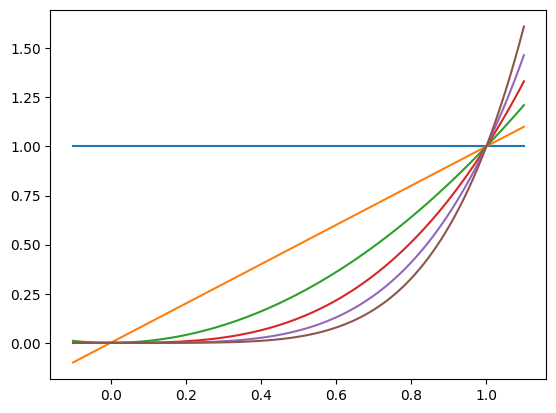

In [4]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
X, Y = np.asarray(X_train), np.asarray(Y_train)

x_train = np.linspace(0, 1, 100)[:, np.newaxis]
x_plot = np.linspace(-0.1, 1.1, 100)[:, np.newaxis]
pol = PolynomialFeatures(degree=5).fit(x_train)
plt.plot(x_plot, pol.transform(x_plot))

# get PHI matrix (p x J*d)

# (be careful ~ singular matrix)
PHI = np.concatenate([pol.transform(X[:, dd][:, np.newaxis]) for dd in range(d)], axis=1)
display(pd.DataFrame(PHI))


# forcing non singularity
eps = 1e-10
P = PHI @ np.linalg.inv(PHI.T @ PHI + eps*np.identity(len(PHI.T))) @ PHI.T

# function to capture phi(X)

In [5]:
# line added for simplification (until other issues are resolved)
Y = np.asarray(Y_train)

estimated K = 2


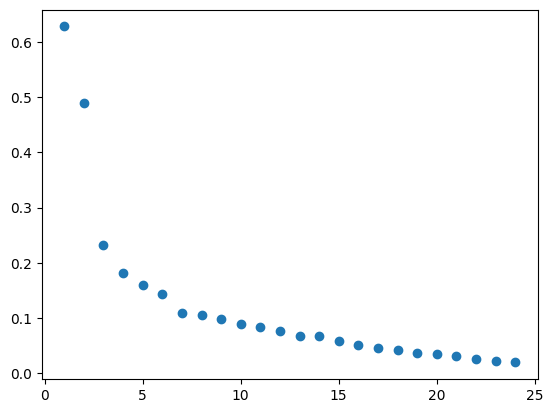

In [6]:
# pt.2 ~ PCA (goal: loading factors F)

def PCA(M : np.ndarray, K : int = 0, plot:bool = False) -> np.ndarray :
    
    # get eigenvalues and eigenvectors
    values, vectors = np.linalg.eig(M)
    
    # sort by eigenvalues (decreasing)
    ind = np.argsort(values)[::-1]
    values, vectors = values[ind], vectors.T[ind]
    vectors = vectors.T
    
    # plot eigenvalues
    if plot : 
        plt.scatter(np.arange(1,1+len(ind)), values)
    
    # estimate K
    if not K:
        K = 1 + np.argmax([values[i]/values[i+1] for i in range(len(values)-1)])
        print(f"estimated K = {K}")
        
    # return K first eigenvectors
    return np.asarray(vectors[:,:K])

# calculate loading factors
T = Y.shape[1]
F_hat = PCA(1/T * Y.T @ P @ Y, K = 0, plot = True)

In [7]:
# pt.3 ~ remaining estimations (goal: GAMA and B)

# est. G(X), lambda, gamma
Gx = 1/T * P @ np.asarray(Y) @ F_hat
LAMBDA = 1/T * np.asarray(Y) @ F_hat
GAMMA = LAMBDA - Gx

# est. B
eps = 1e-10
B = 1/T * np.linalg.multi_dot([np.linalg.inv(PHI.T @ PHI + eps*np.identity(len(PHI.T))), PHI.T, Y, F_hat]) 

In [8]:
Y_pred = LAMBDA @ F_hat.T
Y_pred = pd.DataFrame(Y_pred)

display(Y_pred.head())
display(Y_train.head())

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.002675,-0.001481,-0.005646,0.003471,0.001832,0.002106,-0.003238,0.001303,-0.000476,0.002843,...,0.001985,-0.000009,-0.000231,0.001290,-0.001389,0.000885,0.000242,0.000342,-0.000805,0.000238
1,0.002754,-0.001557,0.000092,0.005647,-0.000551,-0.000451,-0.000508,0.000912,0.002679,-0.001712,...,-0.002298,-0.001783,0.004274,0.000510,-0.000939,0.000303,-0.001577,-0.005183,0.002368,0.003995
2,-0.002480,-0.000721,-0.004024,0.001267,0.001416,0.001589,-0.002189,0.000731,-0.000905,0.002378,...,0.001894,0.000371,-0.001068,0.000807,-0.000787,0.000564,0.000505,0.001339,-0.001072,-0.000676
3,0.000628,-0.003015,-0.004917,0.009246,0.001027,0.001380,-0.003431,0.002152,0.002500,0.000658,...,-0.000743,-0.001954,0.004458,0.001703,-0.002260,0.001118,-0.001505,-0.005351,0.001868,0.004571
4,0.000195,-0.001744,-0.003027,0.005289,0.000669,0.000879,-0.002073,0.001259,0.001350,0.000523,...,-0.000297,-0.001077,0.002443,0.001011,-0.001323,0.000666,-0.000816,-0.002928,0.000984,0.002531


,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,...,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30
2216850,0.000000,-0.052536,-0.142082,0.056689,0.208154,-0.058178,-0.091953,0.023207,0.049890,0.089820,...,0.071297,0.006238,0.008356,0.061848,0.016602,-0.001507,0.042999,-0.004401,-0.030206,-0.008870
BL59CR9,0.192329,-0.134216,-0.011980,0.179145,0.010442,0.003979,0.007222,-0.022230,0.134288,-0.013576,...,0.010870,-0.096590,0.159341,0.009685,-0.002041,-0.107493,-0.057931,-0.088147,-0.021237,0.057402
2516152,-0.073171,0.005639,-0.107465,0.053628,0.231537,-0.009539,0.311986,0.040050,-0.294859,0.111302,...,0.011905,-0.035238,0.108792,-0.000204,-0.126328,0.071351,-0.017318,0.039547,-0.052045,0.084485
2380863,0.014588,0.002615,-0.103901,0.267153,-0.200461,-0.075723,-0.228482,0.030426,-0.085875,-0.088745,...,-0.106818,-0.033134,0.145643,0.144618,-0.068567,0.022838,0.009355,-0.081778,0.114544,0.085030
2931205,-0.007764,0.059468,-0.049766,0.145312,-0.043656,0.071802,-0.086899,0.002928,0.039730,-0.093089,...,-0.064364,0.106308,-0.012812,0.174736,-0.006102,-0.087442,-0.016617,-0.100187,-0.037732,0.118090


(20,)

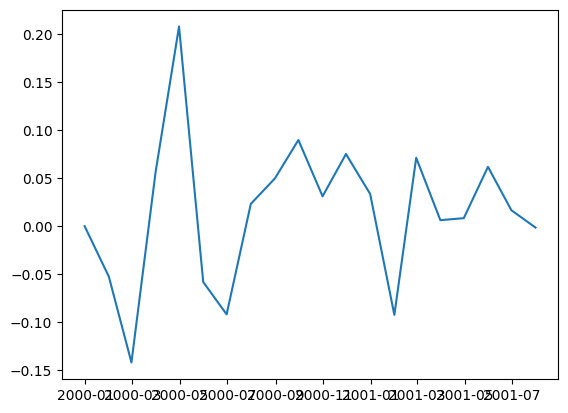

In [10]:
X_train, X_test, Y_train, Y_test = get_data_(0,20, 'std')

plt.plot(Y_train.iloc[0, :])

np.asarray(Y_train)[0].shape

In [11]:
def get_data(start_date: int = 0, final_date: int = 24, shape: str = '') -> tuple[pd.DataFrame, pd.DataFrame] :
        
    entreprises_considerees = 180
    
    parse = lambda  x : pd.read_csv(f'./data/{x}', index_col = 0, parse_dates = True)

    # filter NaN values
    data_list = [parse(file).iloc[start_date:final_date+1,:] for file in file_names if file != '44.csv']
    asset_names = set.intersection(*[set(df.dropna(axis=1).columns.values) for df in data_list])
    
    # get features
    
    intervalle_entrainement = [start_date, final_date]
    F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
    F_train.columns = list(char_names[:-1])
    
    # get input data
    X_train = pd.DataFrame(data=[df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=0) for df in data_list], index=list(char_names[:-1])).T
    
    # get returns [range]
    Y = parse('44.csv')[asset_names].T
    Y_train = Y.iloc[0:entreprises_considerees,intervalle_entrainement[0]:intervalle_entrainement[1]+1] 
    
    # choice of shapes'
    # normalize (column ~ [0 mean, 1 std])
    if shape == 'norm':
        norm  = lambda x : (x-x.mean())/x.std()
        X_train = norm(X_train)
        Y_train = norm(Y_train)

    # scale (column ~ [0,1] range)
    elif shape == 'scale':
        scale = lambda x : (x-x.min())/(x.max()-x.min())
        X_train = scale(X_train)
        Y_train = scale(Y_train)


    return X_train, Y_train, F_train

/tmp/ipykernel_12875/618949907.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
/tmp/ipykernel_12875/618949907.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
/tmp/ipykernel_12875/618949907.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
/tmp/ipykernel_12875/618949907.py:14:

(21,)

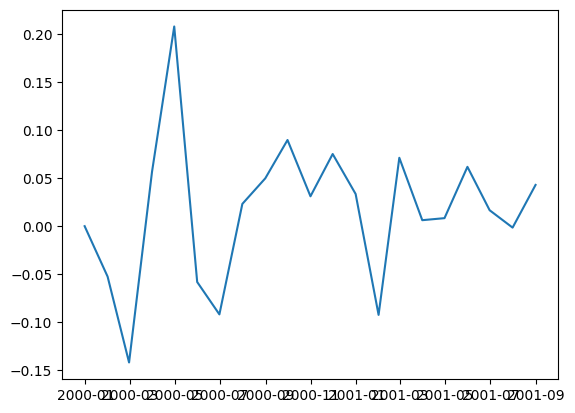

In [14]:
X_train, Y_train, F_train = get_data(0,20, 'std')

plt.plot(Y_train.iloc[0, :])
np.asarray(Y_train)[0].shape

In [ ]:
# # pt.4 ~ predictions 

# predict = lambda X : (phi(spl, X) @ B + GAMMA) @ F_hat.T

# # in sample
# Y_pred_in_sample = predict(X_train)
# Y_pred_in_sample = pd.DataFrame(data=Y_pred_in_sample, columns=Y.columns, index=Y.index)
# print('Frobenius error: ' + str(np.linalg.norm(Y_pred_in_sample - Y_train)))
# print(f'Estimations in sample {Y_train.columns[0]} ~ {Y_train.columns[-1]}')
# display(Y_pred_in_sample)

# # next date (month)
# Y_pred = predict(X_test)
# Y_pred = pd.DataFrame(data=Y_pred, columns=Y_test.columns, index=Y.index)
# print(f'Estimations for {Y_test.columns[-1]}')
# display(pd.DataFrame(data=[Y_test.iloc[:,-1], Y_pred.iloc[:,-1]], index=['True', 'Pred']).T)